<a href="https://colab.research.google.com/github/sundonam/test/blob/main/ch4_01_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B6%84%EB%A5%98_RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **텍스트마이닝(윤상혁 교수)**
## ch3. 데이터분류
## ch3_01. RandomForest


---


## 기초 분류 모델 만들기

## 라이브러리 설치
필요 라이브러리 설치를 위해 아래에 주석 처리(#)을 지우고 셀 왼쪽에 셀 실행 버튼(세모 모양)을 눌러 실행한다.


● koreanize-matplotlib : 한글폰트 사용을 위해    
● tqdm : 오래 걸리는 작업의 진행상태를 보기 위해     
● konlpy : 한국어 형태소 분석을 위해           


In [ ]:
# 데이터 분석을 위한 pandas, 수치계산을 위한 numpy, 시각화를 위한 seaborn, matplotlib 을 불러온다.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
!pip install -qU koreanize-matplotlib konlpy tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 22.3 MB/s eta 0:00:00


필요 라이브러리를 미리 임포트해 둔다.

## 시각화를 위한 폰트 설정


<Axes: title={'center': '한글'}>

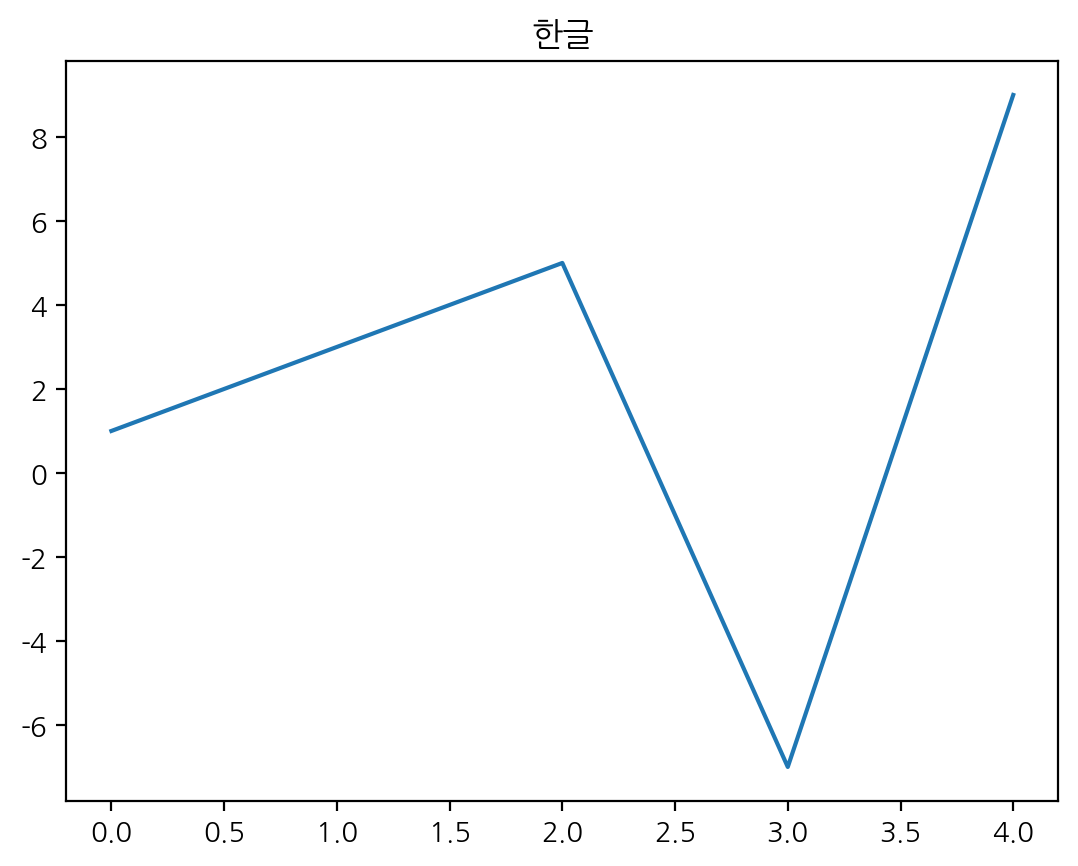

In [ ]:
import koreanize_matplotlib

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

pd.Series([1, 3, 5, -7, 9]).plot(title="한글")

## 데이터 로드

In [ ]:
# 데이콘의 해당 데이터셋은 CC-BY-4.0 라이센스입니다.
# 데이터 출처 : https://dacon.io/competitions/official/235747/data

import os, platform

base_path = "data/klue/"
file_name = "dacon-klue-open-zip"

def file_exist_check(base_path):
    if os.path.exists(f"{base_path}train_data.csv"):
        print(f"{os.getcwd()}/{base_path} 경로에 파일이 있음")
        return

    if not os.path.exists(base_path):
        os.makedirs(base_path)

    if platform.system() == "Linux":
        print(f"파일을 다운로드 하고 {base_path} 경로에 압축을 해제함")
        !wget https://bit.ly/{file_name}
        !unzip {file_name} -d {base_path}
        return
    else:
        print(f"""https://dacon.io/competitions/official/235747/data 에서 다운로드 하고
              실습 경로 {os.getcwd()}/{base_path}에 옮겨주세요.""")
        return

file_exist_check(base_path)

파일을 다운로드 하고 data/klue/ 경로에 압축을 해제함
--2025-06-27 11:11:18--  https://bit.ly/dacon-klue-open-zip
Resolving bit.ly (bit.ly)... 67.199.248.11, 67.199.248.10
Connecting to bit.ly (bit.ly)|67.199.248.11|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://drive.google.com/uc?export=download&id=1jPnwbGKd4eCIZzt5fZshyPf4stGdvcJC [following]
--2025-06-27 11:11:18--  https://drive.google.com/uc?export=download&id=1jPnwbGKd4eCIZzt5fZshyPf4stGdvcJC
Resolving drive.google.com (drive.google.com)... 142.250.152.113, 142.250.152.100, 142.250.152.102, ...
Connecting to drive.google.com (drive.google.com)|142.250.152.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1jPnwbGKd4eCIZzt5fZshyPf4stGdvcJC&export=download [following]
--2025-06-27 11:11:18--  https://drive.usercontent.google.com/download?id=1jPnwbGKd4eCIZzt5fZshyPf4stGdvcJC&export=download
Resolving drive.userconte

In [ ]:
# 학습, 예측 데이터셋을 불러온다.
train = pd.read_csv(os.path.join(base_path, "train_data.csv"))
test = pd.read_csv(os.path.join(base_path, "test_data.csv"))
train.shape, test.shape

((45654, 3), (9131, 2))

In [ ]:
# 토픽을 불러온다.
topic = pd.read_csv(os.path.join(base_path, "topic_dict.csv"))
topic

,topic,topic_idx
0,IT과학,0
1,경제,1
2,사회,2
3,생활문화,3
4,세계,4
5,스포츠,5
6,정치,6


head()와 tail()로 데이터의 전체적인 모양새 확인

In [ ]:
train.head()

,index,title,topic_idx
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4


In [ ]:
test.head()

,index,title
0,45654,유튜브 내달 2일까지 크리에이터 지원 공간 운영
1,45655,어버이날 맑다가 흐려져…남부지방 옅은 황사
2,45656,내년부터 국가RD 평가 때 논문건수는 반영 않는다
3,45657,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것
4,45658,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간


In [ ]:
topic["topic"].values

array(['IT과학', '경제', '사회', '생활문화', '세계', '스포츠', '정치'], dtype=object)

## 전처리를 위한 데이터 병합

In [ ]:
# 전처리를 위해 데이터 병합
raw = pd.concat([train, test])
raw.shape

(54785, 3)

In [ ]:
raw.head()

,index,title,topic_idx
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4.0
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4.0
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4.0
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4.0
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4.0


In [ ]:
raw.tail()

,index,title,topic_idx
9126,54780,인천 오후 3시35분 대설주의보…눈 3.1cm 쌓여,NaN
9127,54781,노래방에서 지인 성추행 외교부 사무관 불구속 입건종합,NaN
9128,54782,40년 전 부마항쟁 부산 시위 사진 2점 최초 공개,NaN
9129,54783,게시판 아리랑TV 아프리카개발은행 총회 개회식 생중계,NaN
9130,54784,유영민 과기장관 강소특구는 지역 혁신의 중심…지원책 강구,NaN


In [ ]:
df = raw.merge(topic, how="left") #left join
df.shape

(54785, 4)

In [ ]:
df.head()

,index,title,topic_idx,topic
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4.0,세계
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4.0,세계
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4.0,세계
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4.0,세계
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4.0,세계


## 정답값 빈도수

In [ ]:
# test는 결측치로 되어 있기 때문에 빈도수에 포함되지 않습니다.
df["topic_idx"].value_counts()

,count
topic_idx,
4.0,7629
2.0,7362
5.0,6933
6.0,6751
1.0,6222
3.0,5933
0.0,4824


In [ ]:
# df 로 빈도수를 구했지만 test 데이터는 topic이 결측치라 포함되지 않습니다.
sns.countplot(data=df, y="topic")

## 문자 길이

In [ ]:
# 문자 길이, 단어 빈도, 유일 어절의 빈도수를 알기 위한 파생 변수 만들기
df["len"] = df["title"].apply(lambda x : len(x))
df["word_count"] = df["title"].apply(lambda x : len(x.split()))
df["unique_word_count"] = df["title"].apply(lambda x : len(set(x.split())))

In [ ]:
# 파생변수가 잘 만들어졌는지 확인한다.
df.head()

,index,title,topic_idx,topic,len,word_count,unique_word_count
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4.0,세계,24,5,5
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4.0,세계,30,6,6
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4.0,세계,30,8,8
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4.0,세계,32,7,7
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4.0,세계,25,7,7


 ##  맷플롯립(matplotlib)과 시본(seaborn)을 이용을 이용해 히스토그램으로 시각화

<Axes: xlabel='unique_word_count', ylabel='Count'>

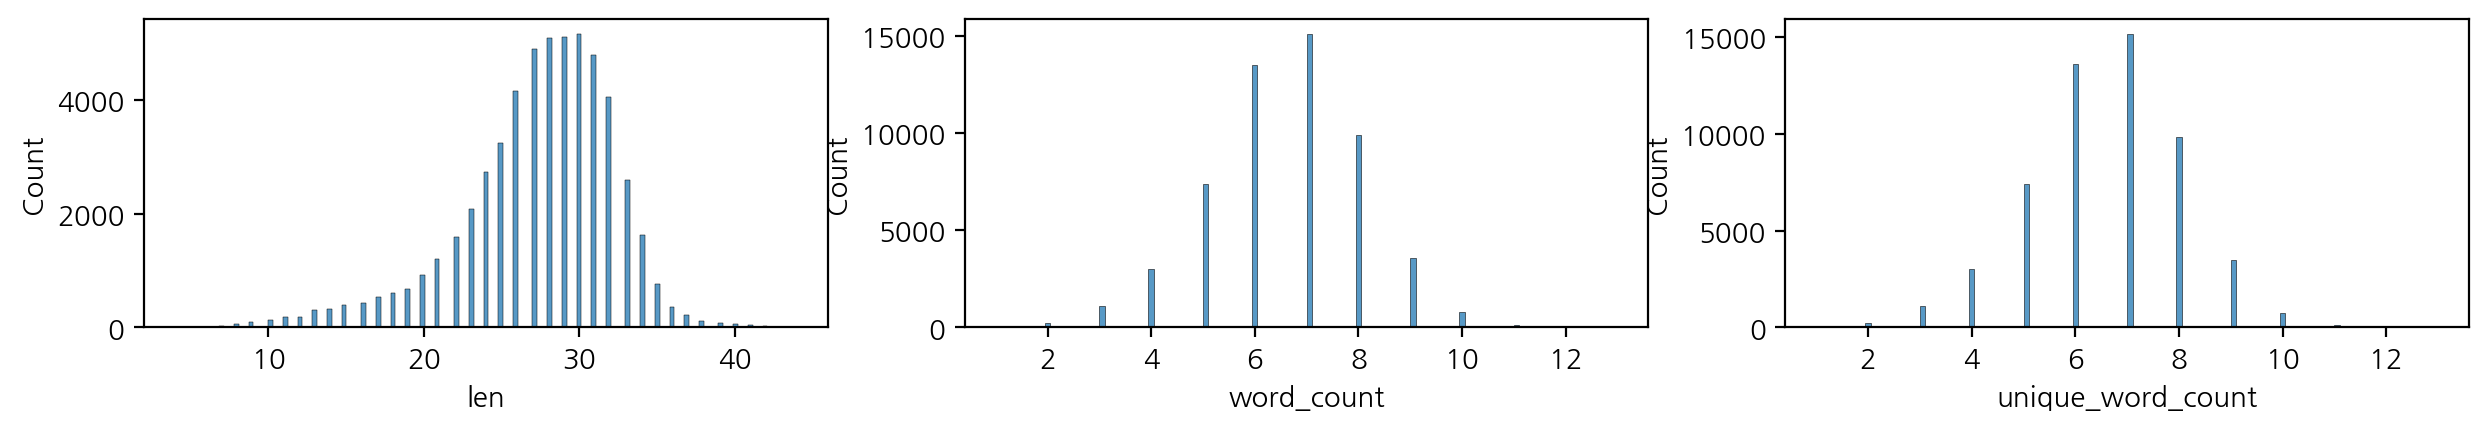

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 2))
sns.histplot(df["len"], ax=axes[0])
sns.histplot(df["word_count"], ax=axes[1])
sns.histplot(df["unique_word_count"], ax=axes[2])

In [ ]:
df[["len", "word_count", "unique_word_count"]].describe()

,len,word_count,unique_word_count
count,54785.000000,54785.000000,54785.000000
mean,27.318846,6.587880,6.576198
std,4.947738,1.471852,1.465320
min,4.000000,1.000000,1.000000
25%,25.000000,6.000000,6.000000
50%,28.000000,7.000000,7.000000
75%,31.000000,8.000000,8.000000
max,44.000000,13.000000,13.000000


### 주제별 글자와 단어 수 확인

### 낱글자의 길이(len) 빈도

In [ ]:
sns.displot(data=df, x="len",
            hue="topic", col="topic", col_wrap=2, aspect=5, height=2) #col_wrap: 한줄에 2개식, aspect: 가소세로 비율, height: 높이 인치

### 단어 빈도

In [ ]:
sns.displot(data=df, x="word_count",
            hue="topic", col="topic", col_wrap=2, aspect=5, height=2)

유일 어절의 빈도

In [ ]:
sns.displot(data=df, x="unique_word_count",
            hue="topic", col="topic", col_wrap=2, aspect=5, height=2)

## 문자 전처리

### 숫자 제거

In [ ]:
import re #정규표현식 사용
# df["title"] = df["title"].map(lambda x : re.sub("[0-9]", "", x))
df["title"] = df["title"].str.replace("[0-9]", "", regex=True)

### 영문자는 모두 소문자로 변경

대소문자가 섞여 있으면 다른 다른 단어로 다루기 때문에 영문자는 모두 대문자 혹은 소문자로 변경합니다.

In [ ]:
df["title"] = df["title"].str.lower()

In [ ]:
df["title"]

,title
0,인천→핀란드 항공기 결항…휴가철 여행객 분통
1,실리콘밸리 넘어서겠다…구글 조원 들여 美전역 거점화
2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것
3,nyt 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합
4,시진핑 트럼프에 중미 무역협상 조속 타결 희망
...,...
54780,인천 오후 시분 대설주의보…눈 .cm 쌓여
54781,노래방에서 지인 성추행 외교부 사무관 불구속 입건종합
54782,년 전 부마항쟁 부산 시위 사진 점 최초 공개
54783,게시판 아리랑tv 아프리카개발은행 총회 개회식 생중계


test의 topic_idx는 NaN이었다. 따라서 notnull()과 isnull()을 사용하여 topic 이 있으면 학습 데이터, 없으면 시험 데이터 세트로 재분할한다.

### 불용어 제거

In [ ]:
# 불용어 제거
def remove_stopwords(text):
    tokens = text.split(' ')
    stops = [ '합니다', '하는', '할', '하고', '한다',
             '그리고', '입니다', '그 ', ' 등', '이런', ' 것 ', ' 및 ',' 제 ', ' 더 ']
    meaningful_words = [w for w in tokens if not w in stops]
    return ' '.join(meaningful_words)

In [ ]:
df["title"] = df["title"].map(remove_stopwords)

In [ ]:
df['title']

,title
0,인천→핀란드 항공기 결항…휴가철 여행객 분통
1,실리콘밸리 넘어서겠다…구글 조원 들여 美전역 거점화
2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것
3,nyt 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합
4,시진핑 트럼프에 중미 무역협상 조속 타결 희망
...,...
54780,인천 오후 시분 대설주의보…눈 .cm 쌓여
54781,노래방에서 지인 성추행 외교부 사무관 불구속 입건종합
54782,년 전 부마항쟁 부산 시위 사진 점 최초 공개
54783,게시판 아리랑tv 아프리카개발은행 총회 개회식 생중계


### 조사, 어미, 구두점 제거

조나나 어미를 제거하기 위해 문장에 품사 정보를 부착해서 분리할 수 있도록 형태소 분석기를 부착할 것이다. 형태소 분석기는 Konlpy의 OKT 분석기를 쓸 예정이다.

In [ ]:
label_name = "topic_idx"

In [ ]:
train = df[df[label_name].notnull()].copy()
test = df[df[label_name].isnull()].copy()
train.shape, test.shape

((45654, 7), (9131, 7))

In [ ]:
# 형태소 분석기에서 Okt 태거 불러오기

from konlpy.tag import Okt
okt = Okt()

# 어간 추출(stemming) : 조사, 어미, 구두점 제거
def okt_clean(text):
    clean_text = []
    for word in okt.pos(text, stem=True):
        if word[1] not in ['Josa', 'Eomi', 'Punctuation']:
            clean_text.append(word[0])

    return " ".join(clean_text)

from tqdm import tqdm
tqdm.pandas()

train['title'] = train['title'].progress_map(okt_clean)
test['title'] = test['title'].progress_map(okt_clean)

100%|██████████| 9131/9131 [00:11<00:00, 809.02it/s]


## 학습, 시험 데이터 세트 분리

In [ ]:
X_train = train["title"]
X_test = test["title"]

X_train.shape, X_test.shape

((45654,), (9131,))

In [ ]:
y_train = train[label_name]
y_train.value_counts()

,count
topic_idx,
4.0,7629
2.0,7362
5.0,6933
6.0,6751
1.0,6222
3.0,5933
0.0,4824


In [ ]:
y_test = test[label_name]
y_test.value_counts()

## 벡터화

### TF-IDF(Term Frequency - Inverse Document Frequency)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(tokenizer=None,
                             ngram_range=(1,2),
                             min_df=3,
                             max_df=0.95)
tfidf_vect.fit(X_train)

TfidfVectorizer(max_df=0.95, min_df=3, ngram_range=(1, 2))

In [ ]:
train_feature_tfidf = tfidf_vect.transform(X_train)
test_feature_tfidf = tfidf_vect.transform(X_test)

train_feature_tfidf.shape, test_feature_tfidf.shape

((45654, 26053), (9131, 26053))

In [ ]:
# 단어 사전
vocab = tfidf_vect.get_feature_names_out()
print(len(vocab))
vocab[:10]

26053


array(['aa', 'abs', 'abu', 'ac', 'ac 밀란', 'acl', 'acl 차다', 'afc',
       'afc 챔스리그', 'afc 챔피언스리그'], dtype=object)

In [ ]:
# np.sum 으로 위에서 구한 train_feature_vector 의 값을 모두 더한다. axis=0 으로 한다.
dist = np.sum(train_feature_tfidf, axis=0)

vocab_count = pd.DataFrame(dist, columns=vocab)
vocab_count

,aa,abs,abu,ac,ac 밀란,acl,acl 차다,afc,afc 챔스리그,afc 챔피언스리그,...,힐러리 지지,힐러리 트럼프,힐링,힘겹다,힘내다,힘드다,힘들다,힘쓰다,힘차다,힙합
0,1.638704,1.448351,1.443645,1.178914,1.178914,4.714391,1.368398,10.477363,3.615439,1.249048,...,1.159541,9.293351,5.925177,1.924272,3.960517,5.22875,10.003071,1.316283,1.815025,2.356838


<Axes: >

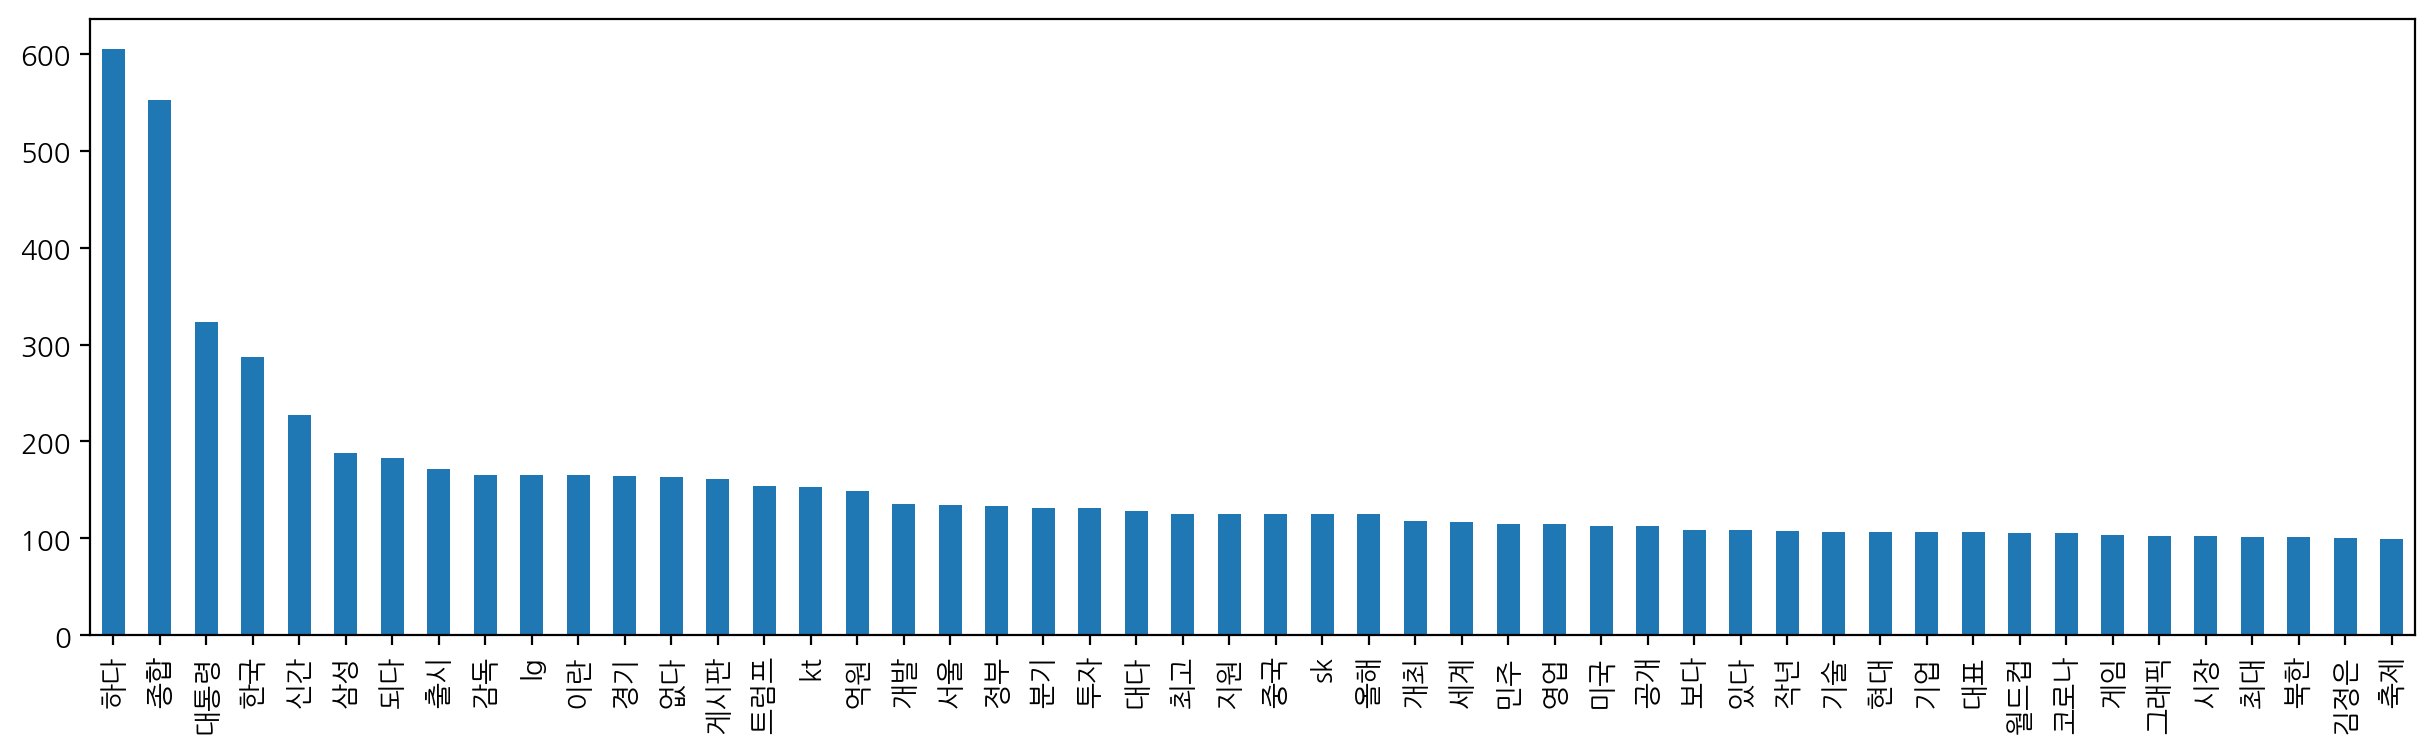

In [ ]:
# 위에서 구한 빈도수를 그래프로 그린다.
vocab_count.T[0].sort_values(ascending=False).head(50).plot.bar(figsize=(15, 4))

## 학습과 예측

In [ ]:
# RandomForestClassifier 를 불러온다.
from sklearn.ensemble import RandomForestClassifier

# 랜덤포레스트 분류기를 사용
model = RandomForestClassifier(n_estimators = 100, n_jobs = -1, random_state=42) #n_estimators: 결정트리 개수, n_jobs: cpu코어수
model

RandomForestClassifier(n_jobs=-1, random_state=42)

### 교차 검증

https://scikit-learn.org/stable/modules/cross_validation.html

In [ ]:
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(model, train_feature_tfidf, y_train, cv=3, n_jobs=-1, verbose=1)#cv: 검정 폴드의 개수, verbose: 진행상황 출력

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  5.4min finished


### 교차 검증 정확도

In [ ]:
valid_accuracy = (y_pred == y_train).mean()
valid_accuracy

np.float64(0.7697901607745214)

In [ ]:
df_accuracy = pd.DataFrame({"pred": y_pred, "train": y_train})
df_accuracy["accuracy"] = (y_pred == y_train)

### 추가 작업(그룹별 정확도)

In [ ]:
topic

,topic,topic_idx
0,IT과학,0
1,경제,1
2,사회,2
3,생활문화,3
4,세계,4
5,스포츠,5
6,정치,6


In [ ]:
df_accuracy.groupby(["train"])["accuracy"].mean()

,accuracy
train,
0.0,0.811360
1.0,0.728544
2.0,0.624287
3.0,0.806843
4.0,0.725652
5.0,0.902784
6.0,0.817509


In [ ]:
df_accuracy.rename(columns={"pred":"predict"})

,predict,train,accuracy
0,2.0,4.0,False
1,1.0,4.0,False
2,4.0,4.0,True
3,6.0,4.0,False
4,4.0,4.0,True
...,...,...,...
45649,1.0,1.0,True
45650,2.0,2.0,True
45651,1.0,1.0,True
45652,2.0,2.0,True


### 학습


In [ ]:
# fit 으로 학습
%time model.fit(train_feature_tfidf, y_train)

CPU times: user 3min 46s, sys: 943 ms, total: 3min 47s
Wall time: 2min 10s


RandomForestClassifier(n_jobs=-1, random_state=42)

### 예측

In [ ]:
# predict로 예측
y_predict = model.predict(test_feature_tfidf)
y_predict[:5]

array([2., 3., 0., 2., 3.])

## 답안지 로드

sample_submission.csv 파일은 마치 답안지와 같다.

In [ ]:
submit = pd.read_csv(os.path.join(base_path, "sample_submission.csv"))
submit.head()

,index,topic_idx
0,45654,0
1,45655,0
2,45656,0
3,45657,0
4,45658,0


In [ ]:
# 정답값 측정을 위해 y_test 변수에 할당
submit["topic_idx"] = y_predict

In [ ]:
file_name = os.path.join(base_path, f"submit_{valid_accuracy}.csv")
file_name

'data/klue/submit_0.7697901607745214.csv'

In [ ]:
submit.to_csv(file_name, index=False)